# Analysis and insights Python script: Retail market analysis in Madrid
## Part 3: Data preparation

### In this part we are going to create new variables or transform the current ones to carry out the actual analysis in Part 4.

## Import the libraries

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy as sa
import folium

## Import the data

In [23]:
con = sa.create_engine('sqlite:///data/airbnb.db')

df = pd.read_sql("df", con = con)

df.head()

,index,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,description,host_is_superhost,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location,price_m2
0,0,6369,"Rooftop terrace room , ensuite bathroom",13660,Chamartín,Hispanoamérica,40.45724,-3.67688,Private room,90,...,Excellent connection with the AIRPORT and EXHI...,t,2,1.0,1.0,102,4.87,4.86,4.83,5590
1,1,21853,Bright and airy room,83531,Latina,Cármenes,40.40381,-3.74130,Private room,31,...,We have a quiet and sunny room with a good vie...,f,1,1.0,1.0,33,4.58,4.82,4.21,2476
2,2,24805,Gran Via Studio Madrid,346366726,Centro,Universidad,40.42183,-3.70529,Entire home/apt,92,...,"Studio located 50 meters from Gran Via, next t...",f,3,1.0,1.0,25,4.88,5.00,5.00,5205
3,3,26825,Single Room whith private Bathroom,114340,Arganzuela,Legazpi,40.38975,-3.69018,Private room,29,...,Nice and cozy roon for one person with a priva...,t,1,1.0,1.0,173,4.70,4.71,4.74,4331
4,4,37921,Piso barrio de salamanca,162926,Salamanca,Recoletos,40.42325,-3.68281,Private room,20,...,<b>The space</b><br />Piso de 3 habitaciones y...,f,8,3.0,6.0,0,NaN,NaN,NaN,6633


## Preparing the variables

### Create the KPIs variables

First we are going to create the analysis variables, the ones we identified as KPIs and we are going to use as levers which affect the business.

These were 3:
- **Renting price**: we already have this one under the variable "price". But we are going to check it to make sure we understand it.
- **Availability**: we have "availability_365" but we need to transform it.
- **Property price**: we will have to create this one with external variables. It's going to be the last variable to be considered.

**Let's start with the renting price**

The dataset does not say if this price is for the whole property or if it is the renting price for a bedroom in case of a bedroom.

This is very important, so we are going to analyse the average renting price by type of renting property.

Let's look at the district with more data to make that analysis.

In [24]:
df["neighbourhood_group"].value_counts().head(10)

Centro               8932
Salamanca            1335
Chamberí             1132
Arganzuela           1022
Tetuán                926
Retiro                710
Carabanchel           673
Ciudad Lineal         589
Chamartín             582
Moncloa - Aravaca     566
Name: neighbourhood_group, dtype: int64

In [25]:
df.query('neighbourhood_group == "Centro"').groupby("room_type")["price"].agg("mean")

room_type
Entire home/apt    176.730443
Private room        97.631151
Shared room        101.375000
Name: price, dtype: float64

Conclusions:
- Renting an entire apartment in the city center the average price is 176.
- Renting a private room or a shared room has an average price of 97€ and 101, respectively.
- It is clear that to compute the income of a property we need to take into account the number of bedrooms when the room type is Private or Shared room.

Multiplying the renting price by the number of bedrooms would not be accurate. You can have a property with more than one bedroom, but not being able to rent them all 100% of the time.

We should take into account the average number of bedrooms rented for each property. But we don't know it!

We are going to assume that we talked to the business owner and we have been told that such value is around 70%.

Let's create the variable total_price applying a custom function.

In [26]:
def create_total_price(record):
    if (record["beds"] > 1) & ((record["room_type"] == 'Private room') | (record["room_type"] == 'Shared room')):
        output = record["price"] * record["beds"] * 0.7
    else:
        output = record["price"]
    return(output)

df['total_price'] = df.apply(create_total_price, axis = 1)

Check that it worked correctly.

In [27]:
df[(df["room_type"] == "Private room") & (df["beds"] > 1)][["room_type","price","beds","total_price"]]

,room_type,price,beds,total_price
4,Private room,20,6.0,84.0
8,Private room,64,2.0,89.6
21,Private room,30,2.0,42.0
27,Private room,28,2.0,39.2
35,Private room,42,2.0,58.8
...,...,...,...,...
19443,Private room,50,2.0,70.0
19444,Private room,50,3.0,105.0
19456,Private room,21,2.0,29.4
19460,Private room,32,2.0,44.8


**Let's check the availability**

The variable we use for that is availability_365. It says how many days in a year time the property is NOT occupied.

We are going to transform it to the % of the year that it actually is occupied.

In [28]:
df["occupancy_rate"] = ((365 - df["availability_365"]) / 365 * 100).astype("int")
df.head()

,index,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location,price_m2,total_price,occupancy_rate
0,0,6369,"Rooftop terrace room , ensuite bathroom",13660,Chamartín,Hispanoamérica,40.45724,-3.67688,Private room,90,...,2,1.0,1.0,102,4.87,4.86,4.83,5590,90.0,83
1,1,21853,Bright and airy room,83531,Latina,Cármenes,40.40381,-3.74130,Private room,31,...,1,1.0,1.0,33,4.58,4.82,4.21,2476,31.0,5
2,2,24805,Gran Via Studio Madrid,346366726,Centro,Universidad,40.42183,-3.70529,Entire home/apt,92,...,3,1.0,1.0,25,4.88,5.00,5.00,5205,92.0,80
3,3,26825,Single Room whith private Bathroom,114340,Arganzuela,Legazpi,40.38975,-3.69018,Private room,29,...,1,1.0,1.0,173,4.70,4.71,4.74,4331,29.0,5
4,4,37921,Piso barrio de salamanca,162926,Salamanca,Recoletos,40.42325,-3.68281,Private room,20,...,8,3.0,6.0,0,NaN,NaN,NaN,6633,84.0,20


### Tranformation of analysis variables

Some seed questions directly relate the renting price or the ocupancy rate with other variables such as the number of bedrooms, the average review score, etc.

It is better to carry out these analyses with discretised variables. Then, we are going to discretise:

- Accommodates
- Bedrooms
- Beds
- Number of reviews

**Discretise bedrooms**

First we evaluate the data distribution

<AxesSubplot:>

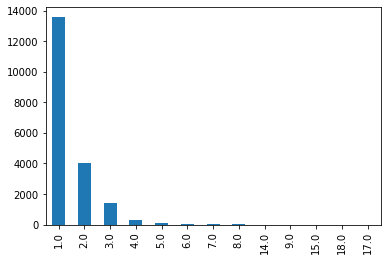

In [29]:
df["bedrooms"].value_counts().sort_values(ascending=False).plot.bar()

We are going to discretise for 1,2,3 and more than 3.

In [30]:
conditions = [df["bedrooms"] == 1,
                df["bedrooms"] == 2,
                df["bedrooms"] == 3,
                df["bedrooms"] > 3]

results = ["01_One", "02_Two", "03_Three", "04_Four or more"]

df["bedrooms_disc"] = np.select(conditions, results, default=-999)

Check it worked correctly

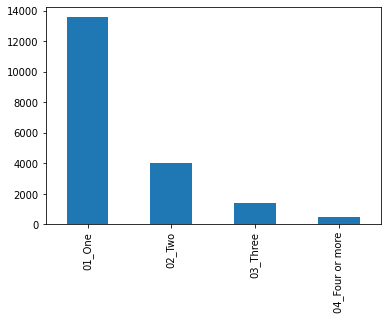

In [31]:
df["bedrooms_disc"].value_counts().plot.bar();

**Discretise accommodates, beds and number_of_reviews**

We are going to automatically discretise these variables with qcut with percentiles 0.5, 0.8 and 1.

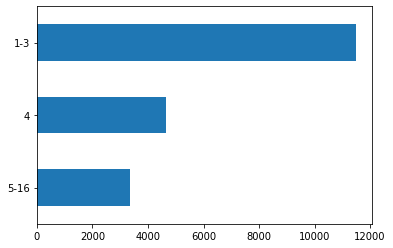

In [32]:
df["accommodates_disc"] = pd.qcut(df["accommodates"],[0, 0.5, 0.8, 1],
                                 labels = ['1-3','4','5-16'])

df["accommodates_disc"].value_counts().sort_index(ascending = False).plot.barh();

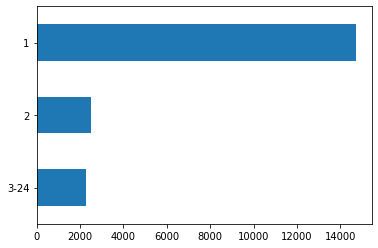

In [33]:
df["beds_disc"] = pd.qcut(df["beds"],[0, 0.5, 0.8, 1],
                         labels = ['1','2','3-24'])

df["beds_disc"].value_counts().sort_index(ascending = False).plot.barh();

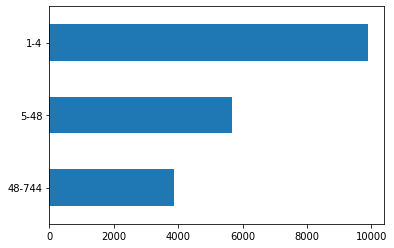

In [34]:
df["number_of_reviews_disc"] = pd.qcut(df["number_of_reviews"],[0, 0.5, 0.8, 1],
                                      labels = ['1-4','5-48','48-744'])

df["number_of_reviews_disc"].value_counts().sort_index(ascending = False).plot.barh();

### Create variables with external data

Here we are going to:
- Estimate the property size in m<sup>2</sup>.
- Compute the distance from each property to the city center.

**Proerty size in m<sup>2</sup>**

We already know the price per m<sup>2</sup>. Now we need to know the property size so we can compute the property price.

A good approximation will be to estimate the property size for some given number of bedrooms.

In this case:
- 1 bedroom: 50m<sup>2</sup>
- 2 bedroom: 70m<sup>2</sup>
- 3 bedroom: 90m<sup>2</sup>
- 4 bedroom: 120m<sup>2</sup>
- 5 or more bedrooms: 150m<sup>2</sup>

In [35]:
conditions = [df["bedrooms"] == 1,
                df["bedrooms"] == 2,
                df["bedrooms"] == 3,
                df["bedrooms"] == 4,
                df["bedrooms"] >= 5]

results = [50,70,90,120,150]

df["m2"] = np.select(conditions, results, default=-999)

Check it worked correctly:

In [36]:
df["m2"].value_counts().sort_index()

50     13554
70      4019
90      1419
120      328
150      152
Name: m2, dtype: int64

We can now estimate the property purchase price.

Also note that we assumed a 25% discount to the final price since the business managers can negotiate and lower that price.

In [37]:
df["purchase_price"] = df["price_m2"] * df["m2"] * 0.75

In [38]:
df[["bedrooms","m2","neighbourhood_group","price_m2","purchase_price"]].head(20)

,bedrooms,m2,neighbourhood_group,price_m2,purchase_price
0,1.0,50,Chamartín,5590,209625.0
1,1.0,50,Latina,2476,92850.0
2,1.0,50,Centro,5205,195187.5
3,1.0,50,Arganzuela,4331,162412.5
4,3.0,90,Salamanca,6633,447727.5
5,1.0,50,Centro,5205,195187.5
6,1.0,50,Centro,5205,195187.5
7,1.0,50,Centro,5205,195187.5
8,1.0,50,Centro,5205,195187.5
9,2.0,70,Salamanca,6633,348232.5


**Distance from each town to the city center**



We are going to measure the distance of each property to the city center. The city center is going to be Puerta del Sol.

It latitude and longitude are:

- Latitude: 40.4167278 
- Longitude: -3.7033387

To compute the distance we are going to use the Haversine formula, which takes into account the spherical shape of Earth to measure distances.

The formula is based on the one from [this](https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points) link.

In [39]:
from math import radians, cos, sin, asin, sqrt

def haversine(lat1, lon1, lat2, lon2):

      R = 6372.8 # Earth radius in km. If we wanted to compute the distance in miles we should use 3959.87433.

      dLat = radians(lat2 - lat1)
      dLon = radians(lon2 - lon1)
      lat1 = radians(lat1)
      lat2 = radians(lat2)

      a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
      c = 2*asin(sqrt(a))

      return R * c

We can now create the new variable.

In [40]:
# Coordinates from Plaza de España will be lat1 and lon1
lat1 = 40.4167278
lon1 = -3.7033387

df["distance_center"] = df.apply(lambda record: haversine(lat1,lon1,record["latitude"],record["longitude"]),axis = 1)

Check it works.

In [41]:
df.groupby("neighbourhood_group")["distance_center"].agg("mean").sort_values()

neighbourhood_group
Centro                    0.720685
Arganzuela                1.914219
Chamberí                  2.138527
Retiro                    2.461257
Salamanca                 2.714501
Moncloa - Aravaca         3.149567
Latina                    3.854300
Usera                     3.919806
Carabanchel               3.989676
Chamartín                 4.420761
Puente de Vallecas        4.434896
Tetuán                    4.605550
Moratalaz                 4.946966
Ciudad Lineal             5.262423
Villaverde                7.702260
Fuencarral - El Pardo     7.958108
Hortaleza                 8.079939
San Blas - Canillejas     8.196266
Vicálvaro                 8.953812
Villa de Vallecas         9.172113
Barajas                  11.450702
Name: distance_center, dtype: float64

## Save the data mart

We can now save the whole data set as df_final

In [42]:
df.to_sql("df_final", con = con, if_exists="replace")